In [68]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import (
    model_built_data_paths,
    model_ready_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [93]:
asset_type = "land"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

# metric_key_unsmoothed = "weighted_median"
metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric

In [94]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_built_data_path = model_built_data_paths[dataset_name]
model_ready_data_path = model_ready_data_paths[dataset_name]

df = pd.read_csv(model_built_data_path)
df = df.assign(asset_type=asset_type)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)


<Axes: ylabel='Frequency'>

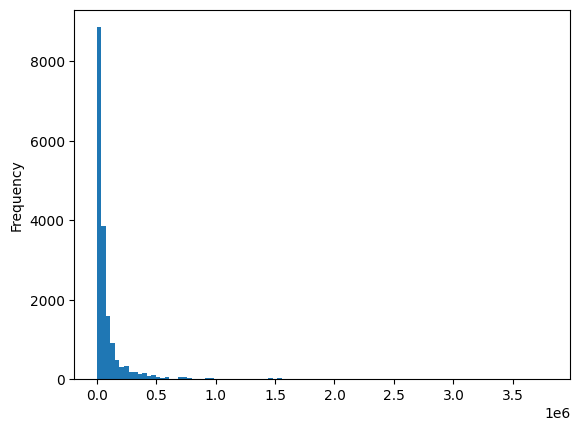

In [95]:
column = "population"
log_column = f"log_{column}"
df[column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

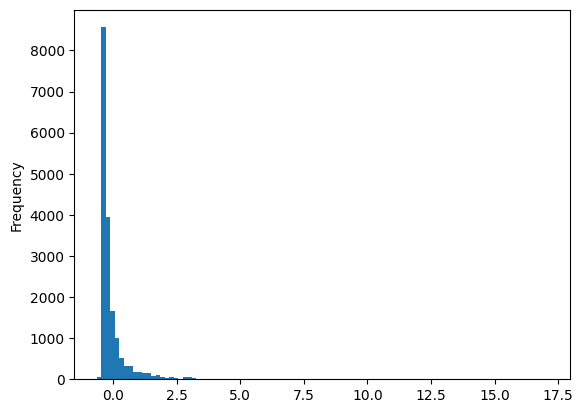

In [96]:
df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
    lambda x: (x - x.mean()) / x.std()
)
df[f"{column}_normalized_yearly"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

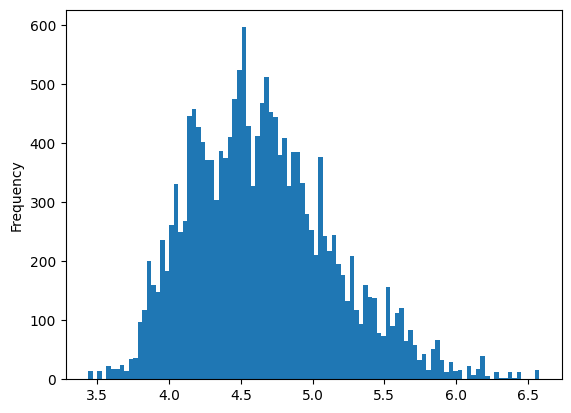

In [97]:
df[log_column] = df[column].apply(lambda x: np.log10(1 + x))
df[log_column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

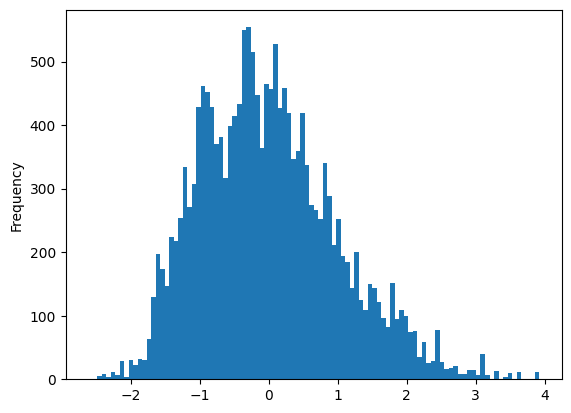

In [98]:
df[f"{log_column}_normalized_yearly"] = df.groupby("year")[log_column].transform(
    lambda x: (x - x.mean()) / x.std()
)
# df[f"{log_column}_normalized_yearly"] = df.groupby("year")[log_column].transform(
#     lambda x: x - x.min() + 1
# )
df[f"{log_column}_normalized_yearly"].plot.hist(bins=100)

In [99]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
]

# log_normalize_columns = []

# normalize_columns = [
#     metric,
#     metric_pct_chg,
#     "count",
#     "total_traded_area",
#     "population",
#     "taxpayer_count",
#     "taxable_income",
#     "taxable_income_per_taxpayer",
#     "taxable_income_growth",
#     "taxable_income_per_taxpayer_growth",
#     "new_dwellings",
#     "existing_dwellings",
#     "new_dwellings_ratio",
#     "net_migration_ratio",
#     "total_tax",
#     "total_tax_growth",
# ]

maintain_columns = [
    metric_pct_chg,
    # "years_since_crisis",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

id_columns = [
    "area_code",
    "area",
    "year",
    "asset_type"
]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [100]:
for column in log_normalize_columns:
    df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
    df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

for column in normalize_columns:
    df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
        lambda x: (x - x.mean()) / x.std()
    )

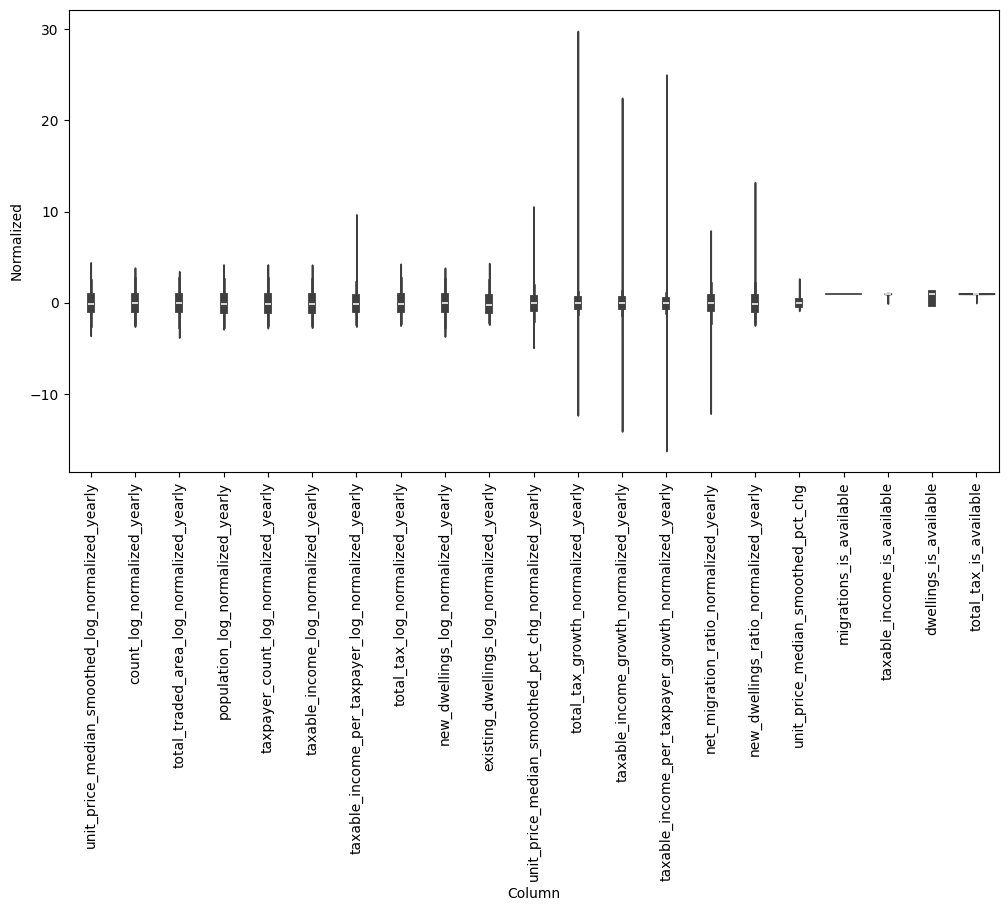

In [101]:
df_std = df[feature_columns].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[feature_columns].keys(), rotation=90)

In [102]:
df[final_columns].describe()

,area_code,year,unit_price_median_smoothed_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_pct_chg,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
count,17737.000000,17737.000000,1.773700e+04,1.773700e+04,1.773700e+04,1.773700e+04,1.648200e+04,1.648200e+04,1.648200e+04,1.769900e+04,1.049600e+04,1.049600e+04,1.773700e+04,1.768400e+04,1.648200e+04,1.648200e+04,1.773700e+04,1.049600e+04,17737.000000,17737.0,17737.000000,17737.000000,17737.000000
mean,21823.732706,2015.481254,5.007490e-18,-2.611907e-16,1.564340e-16,-1.015519e-16,1.695310e-16,-9.387252e-17,-7.018345e-16,-5.301269e-16,-3.114040e-17,-4.275036e-16,5.307939e-18,-3.616198e-18,1.929183e-17,-2.640501e-18,5.307939e-18,-1.076375e-16,-0.019199,1.0,0.929244,0.591757,0.997858
std,13467.199899,4.026581,9.995770e-01,9.995770e-01,9.995770e-01,9.995770e-01,9.995752e-01,9.995752e-01,9.995752e-01,9.995761e-01,9.993328e-01,9.993328e-01,9.995770e-01,9.995758e-01,9.995752e-01,9.995752e-01,9.995770e-01,9.993328e-01,0.167136,0.0,0.256424,0.491522,0.046238
min,1100.000000,2007.000000,-3.340259e+00,-2.327901e+00,-3.532675e+00,-2.616517e+00,-2.483294e+00,-2.439227e+00,-2.318993e+00,-2.219959e+00,-3.386869e+00,-2.078587e+00,-4.655211e+00,-1.205604e+01,-1.381226e+01,-1.595828e+01,-1.187078e+01,-2.178818e+00,-0.829046,1.0,0.000000,0.000000,0.000000
25%,11221.000000,2012.000000,-6.707729e-01,-7.267712e-01,-6.695736e-01,-7.564269e-01,-7.596502e-01,-7.521714e-01,-6.767261e-01,-7.242084e-01,-7.038962e-01,-7.309924e-01,-5.204959e-01,-3.472943e-01,-3.503968e-01,-3.005950e-01,-5.908571e-01,-6.674539e-01,-0.107698,1.0,1.000000,0.000000,1.000000
50%,21206.000000,2015.000000,-1.427060e-01,-5.313857e-02,-2.451564e-02,-8.888892e-02,-9.523189e-02,-1.151682e-01,-1.640788e-01,-1.104175e-01,-6.134257e-02,-2.003979e-01,-1.469947e-02,-5.134713e-02,-2.823088e-02,-2.744725e-02,-3.183799e-02,-9.092110e-02,-0.025749,1.0,1.000000,1.000000,1.000000
75%,33100.000000,2019.000000,5.941250e-01,6.559991e-01,6.708567e-01,6.021104e-01,6.198082e-01,6.161964e-01,4.968303e-01,6.427704e-01,6.190943e-01,5.582414e-01,4.731751e-01,2.683525e-01,3.066325e-01,2.556490e-01,5.200567e-01,4.908768e-01,0.056570,1.0,1.000000,1.000000,1.000000
max,47381.000000,2022.000000,4.156140e+00,3.575007e+00,3.177887e+00,3.920832e+00,3.915662e+00,3.892431e+00,9.405159e+00,3.998590e+00,3.527991e+00,4.040282e+00,1.027584e+01,2.953030e+01,2.219338e+01,2.472971e+01,7.639497e+00,1.291555e+01,2.607923,1.0,1.000000,1.000000,1.000000


In [103]:
df = df.fillna(0)
df.to_csv(model_ready_data_path, index=False)

In [63]:
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(drop=True)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [64]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
0,2007,8.298263e+05,-0.112199,-1.180347
42,2008,8.398828e+05,-0.064469,-1.194733
136,2009,8.215483e+05,-0.009976,0.090992
582,2010,8.000000e+05,-0.047486,-0.240047
842,2011,8.000000e+05,-0.026229,-0.040735
1089,2012,8.564764e+05,0.070595,0.947242
1376,2013,9.000000e+05,0.125000,1.501343
1855,2014,9.498815e+05,0.109057,1.037654
1938,2015,1.000371e+06,0.111523,0.845678
2215,2016,1.050008e+06,0.105409,0.668043


In [65]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]



,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
219,2020,1.227354e+06,0.067131,0.086402
577,2021,1.264954e+06,0.065451,-0.115433
839,2022,1.302790e+06,0.061462,-0.199661


In [283]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
0,2007,2.204983e+06,0.227171,2.619291
135,2008,2.197454e+06,0.139858,1.066988
281,2009,2.069647e+06,-0.061378,-0.060949
1619,2010,1.825045e+06,-0.169473,-0.456003
2934,2011,1.620211e+06,-0.217156,-0.780465
4568,2012,1.684720e+06,-0.076888,-0.332538
6153,2013,1.947510e+06,0.202010,1.113350
7529,2014,2.130575e+06,0.264646,1.446387
7978,2015,2.257352e+06,0.159097,0.843063
9235,2016,2.645833e+06,0.241840,1.197871


In [284]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
525,2020,3.849920e+06,0.257623,1.115681
2079,2021,4.164547e+06,0.225359,0.829393
3735,2022,4.462737e+06,0.159177,0.495757


In [35]:
idx = 3279
row = eval_df.iloc[idx]
target = row[metric_pct_chg + "_normalized_yearly"]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window[feature_columns]

Target: -0.02771966466326222


,unit_price_median_smoothed_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_pct_chg,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
10054,3.915102,-0.834155,-1.872637,0.287149,0.496525,1.377601,7.456790,0.941798,0.952773,0.039909,2.176605,1.236671,3.288324,2.762343,2.943236,3.653636,0.292632,1,1,1,1
10715,4.044191,-1.067941,-2.220274,0.301448,0.510955,1.407383,7.605818,0.959710,0.914704,0.066191,3.129432,0.630169,1.058118,0.652705,3.608020,3.725444,0.474332,1,1,1,1
11659,4.116794,-1.980770,-3.208546,0.318345,0.526450,1.454710,7.871456,0.977459,0.620455,0.089354,2.565694,0.739469,1.681444,1.353259,6.221203,1.645029,0.406302,1,1,1,1
13473,4.156140,-0.986588,-2.121048,0.347793,0.562161,1.539000,8.130541,1.038132,0.502244,0.096044,1.845556,2.696462,3.483632,2.433135,5.354278,1.239253,0.281044,1,1,1,1
14436,4.126905,-0.614521,-1.977137,0.373934,0.594820,1.507795,7.877313,1.004738,0.883671,0.112588,0.726468,-1.277204,-1.154641,-2.890391,3.226812,3.494684,0.130397,1,1,1,1
